# Project 1: Analyzing Spectroscopic data from OMM

In [2]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
from scipy.stats import lognorm

plt.rcParams['figure.figsize'] = (14, 5)

## Part 1: Exploration

We can define a plotting function for our FITS files for repeated plotting down the line

In [3]:
#NOTE: Turn basic fits astropy file manipulations into a class
# class AstropyFits:
#     def __init__(self):
#         self.fits_file = fits_file
#
#     def convert_fits_to_data(self, ):


In [23]:
def plot_fits(data, vmin, vmax, title, norm = None):
    #plot the data...
    fig, ax = plt.subplots()
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap='viridis', origin='lower', norm=norm, aspect='auto')
    ax.set_xlabel('x pixels')
    ax.set_ylabel('y pixels')
    ax.set_title(title)
    fig.colorbar(im)

def fits_to_data(file_name):
    source_file = fits.open(file_name)
    source_data = source_file[0].data
    return source_data, source_file


Let's produce some rough visualizations of the source file, a calibration lamp, and dark frame.

In [24]:
parent = './fit_files/'
source_fits = parent + 'source.fits'
cal_lamp_fits = parent + 'calibration.fits'
bias_frame_fits = parent + 'bias0008.fits'
dark_frame_fits = parent + 'dark0001.fits'

In [25]:
s_data, s_file = fits_to_data(source_fits)
cal_lamp_data, cal_lamp_file = fits_to_data(cal_lamp_fits)
bias_frame_data, bias_frame_file = fits_to_data(bias_frame_fits)
dark_frame_data, dark_frame_file = fits_to_data(dark_frame_fits)

In [26]:
print((s_data.shape))

(512, 2720)


Viewing the header of the source file, we can see the source is Orion and look at other things like photometric results and observing details.

In [16]:
# source_header = s_file[0].header
# print(repr(source_header))

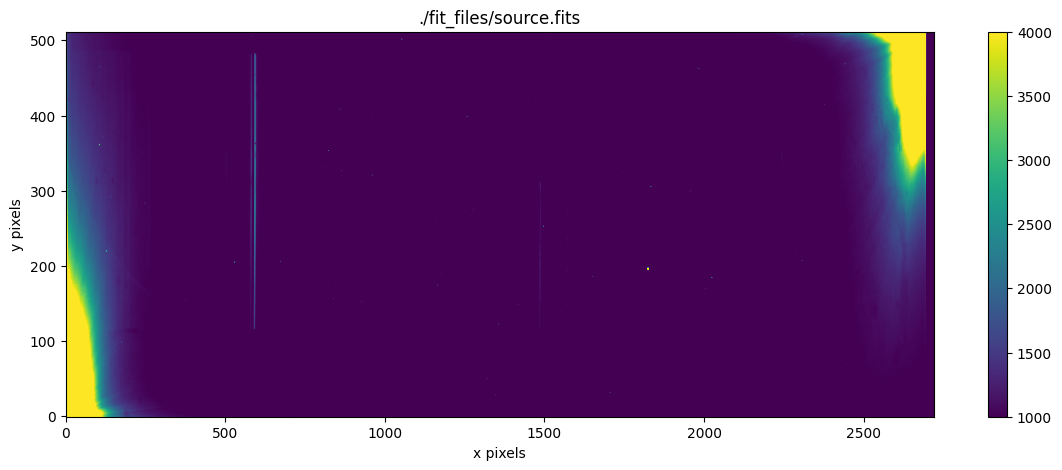

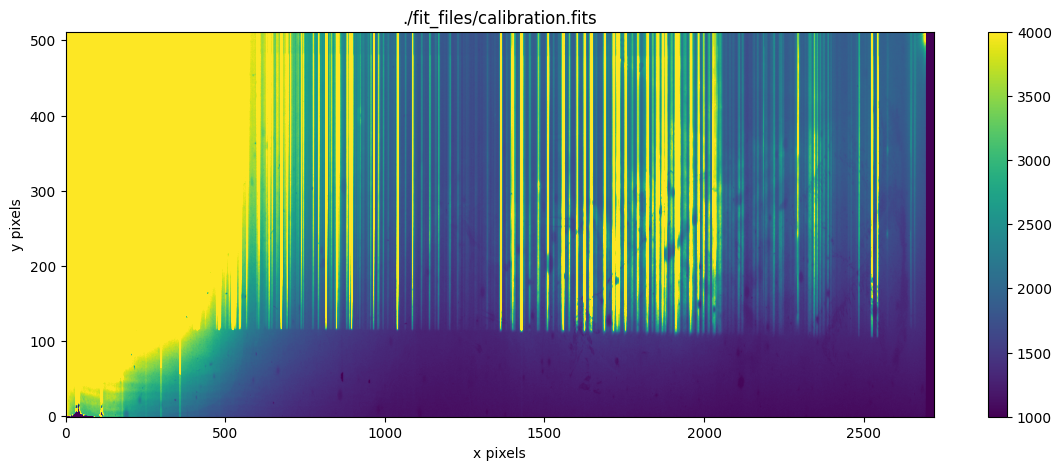

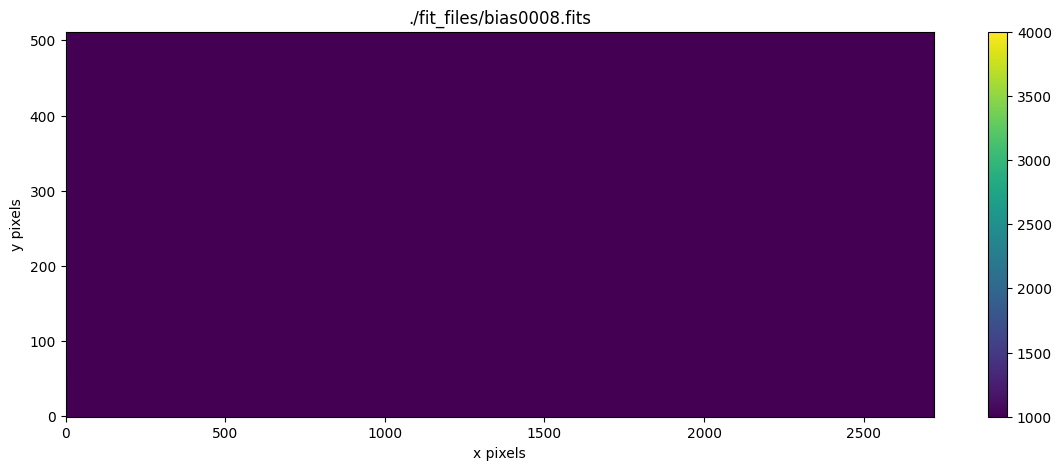

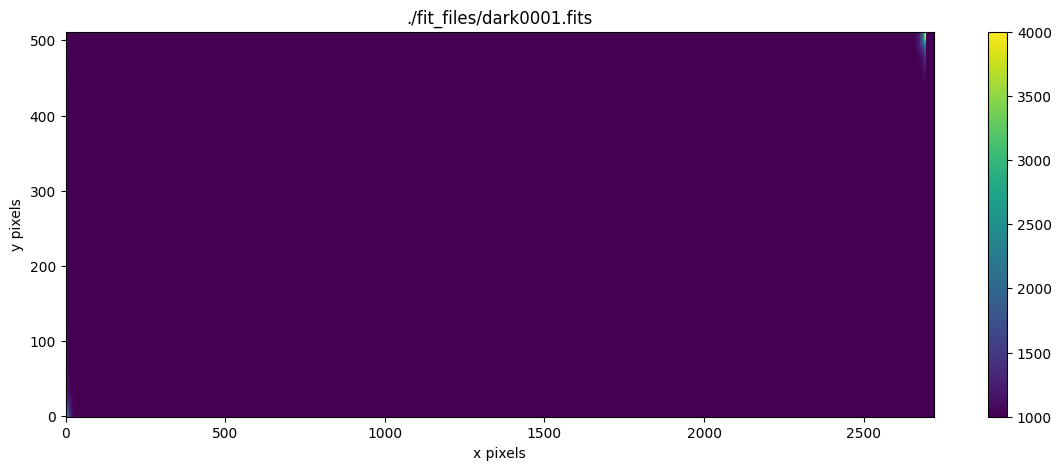

In [27]:
#Now let's plot the different images:
#we need to establish a minimum and maximum range to plot the intensity over
vmin = 1e3
vmax = 4e3

plot_fits(s_data, vmin, vmax, title=source_fits, norm=None)
plot_fits(cal_lamp_data, vmin, vmax, title=cal_lamp_fits, norm=None)
plot_fits(bias_frame_data, vmin, vmax, title=bias_frame_fits, norm=None)
plot_fits(dark_frame_data, vmin, vmax, title=dark_frame_fits, norm=None)


Let's take a look at what the 'data' files look like so we have an idea of what needs to be done algorithmically when trying to compute the PS.

In [10]:
print(type(s_data))
print(s_data)

<class 'numpy.ndarray'>
[[863 859   0 ... 848 852 856]
 [854 856   0 ... 856 847 844]
 [843 842   0 ... 838 847 841]
 ...
 [850 849   0 ... 846 849 841]
 [849 848   0 ... 849 839 850]
 [850 851   0 ... 855 841 847]]


Ok, so the data is just a 2D matrix and morever a Numpy array so we can perform all the basic math operations on it.

Text(0, 0.5, 'photon counts')

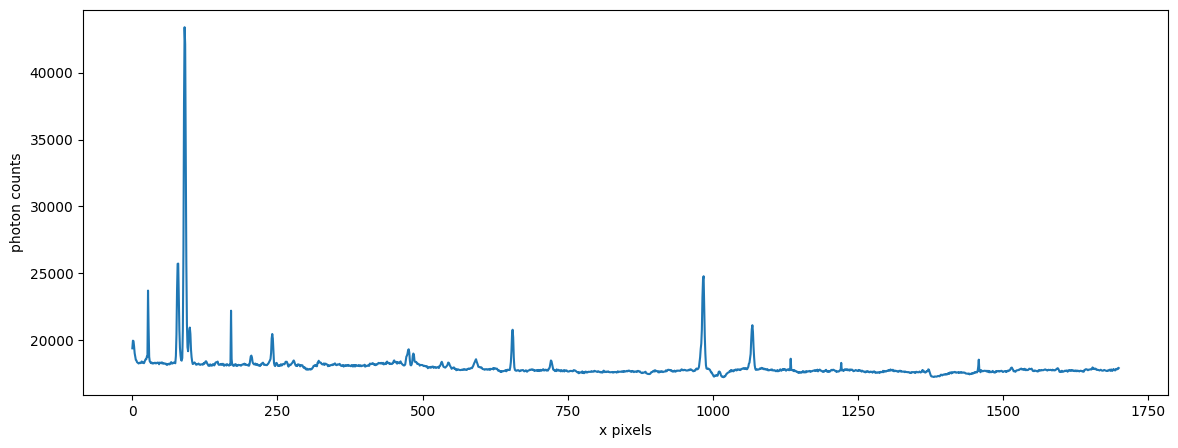

In [29]:
source_spectrum = np.sum(s_data[200:220, 500:2200], axis = 0)
# source_spectrum = np.sum(s_data[200:220], axis = 0)

plt.plot(source_spectrum)
plt.xlabel("x pixels")
plt.ylabel("photon counts")

## Part 2: Noise Removal

### Part 2.1 - Master bias

For the first part of the noise removal, we need to make a master bias frame. According to the project outline a ***bias*** frame is one where a minimum duration exposure was taken without significant light entering the detector. We should take a master bias frame by taking the median of all the bias frames included.

In [106]:
import os

directory = r"./fit_files/bias/"

bias_frames = []
for name in os.listdir(directory):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        # print(name)
        bias_frames.append(name)

bias_data = []
bias_files = []
for fit_file in bias_frames:
    # print(fit_file)
    file_name = directory + fit_file
    # print(file_name)
    data, file = fits_to_data(directory + str(fit_file))
    bias_data.append(data)
    bias_files.append(file)

bias_array = np.zeros((bias_data[0].shape[0], bias_data[0].shape[1], len(bias_data)))
for num, data_file in enumerate(bias_data):
    bias_array[:, :, num] = data_file

median_bias = np.median(bias_array, axis = 2)
# print(median_bias)
# print(median_bias.shape)

Now that we've computed the median bias frame, let's plot it to try and see some of the qualitative features. Plotting first and then using the colorbar to select the a smaller range seems to show a bit more features at the side of the plot.

NOTE: Will need to answer in the write up what the bias frame is trying to correct for, as well as describe in qualitatively.

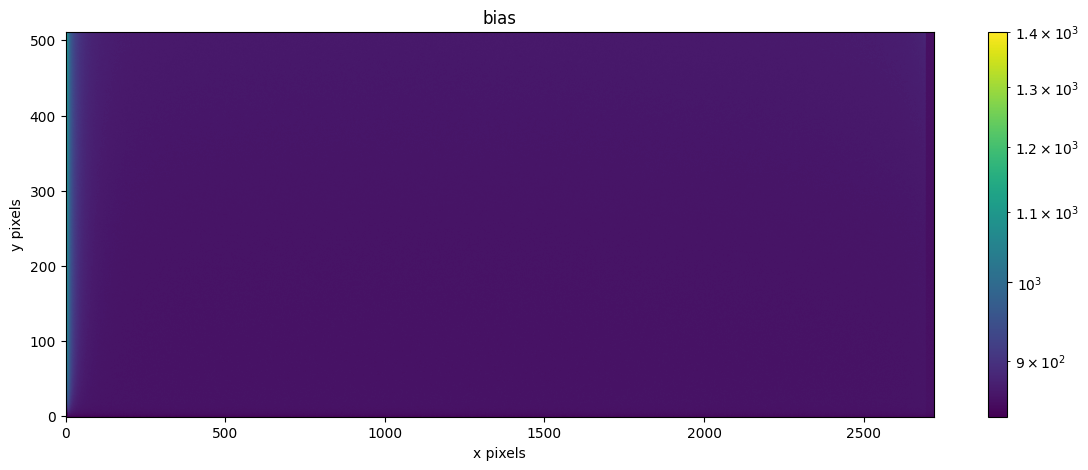

In [108]:
#define again some vmin and vmax
vmin = None
vmax = None
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

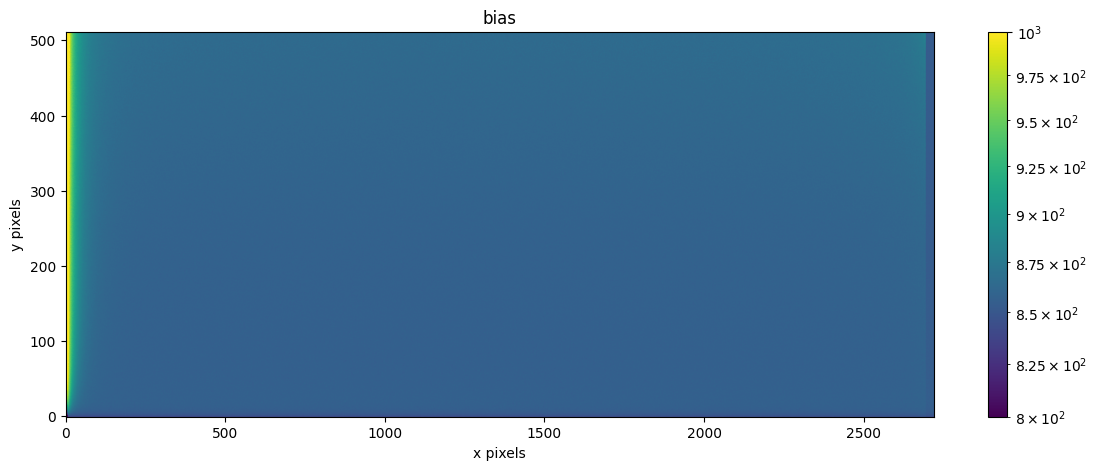

In [109]:
#define again some vmin and vmax
vmin = 800
vmax = 1000
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

Ok, now let's remove the bias from each of the dark, flats, calibration, and source_data, files.

In [149]:
#we have the source data file from befor it's just s_data. Unpacking the other files:
dir = r'./fit_files/dark/'
dark_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        dark_frames.append(name)
# print(dark_frames)

dark_data = []
dark_files = []
for file in dark_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    dark_data.append(data)
    dark_files.append(file)


dir = r'./fit_files/flat/'
flat_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        flat_frames.append(name)
# print(dark_frames)

flat_data = []
flat_files = []
for file in flat_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    flat_data.append(data)
    flat_files.append(file)

dark_bias = []
flat_bias = []
src_bias = []
calibration_bias = []
for num, dark in enumerate(dark_data):
    # print(num)
    # print(dark_data[num])
    dark_data[num] = dark_data[num] - median_bias

print(dark_data)


[array([[-10.5,  -7.5,   0. , ...,  14.5,  15. ,   8. ],
       [  5.5,  14. ,   0. , ...,  13. ,  13.5,   2. ],
       [ 13.5,  12.5,   0. , ...,  10. ,   8. ,   1.5],
       ...,
       [  4.5,   7.5,   0. , ...,  -1.5,   0. ,   8. ],
       [  0. ,   1. ,   0. , ...,  -1. ,   0.5,   3. ],
       [ -7. ,  -2. ,   0. , ...,  -2.5,   0. ,   1. ]]), array([[ 0.5,  2.5,  0. , ...,  5.5,  1. ,  2. ],
       [ 6.5, 14. ,  0. , ..., -1. ,  0.5,  0. ],
       [-1.5, -4.5,  0. , ..., -1. ,  3. ,  0.5],
       ...,
       [14.5,  2.5,  0. , ...,  7.5,  3. , 16. ],
       [ 9. , 10. ,  0. , ...,  4. ,  9.5,  2. ],
       [10. ,  9. ,  0. , ...,  3.5, 12. ,  3. ]]), array([[  9.5, -13.5,   0. , ...,  36.5,  31. ,  38. ],
       [ 34.5,  43. ,   0. , ...,  23. ,  37.5,  32. ],
       [ 26.5,  25.5,   0. , ...,  13. ,  23. ,  23.5],
       ...,
       [ 21.5,  27.5,   0. , ...,  22.5,  27. ,  23. ],
       [ 26. ,  27. ,   0. , ...,  27. ,  27.5,  28. ],
       [ 21. ,  25. ,   0. , ...,  22.5,  1

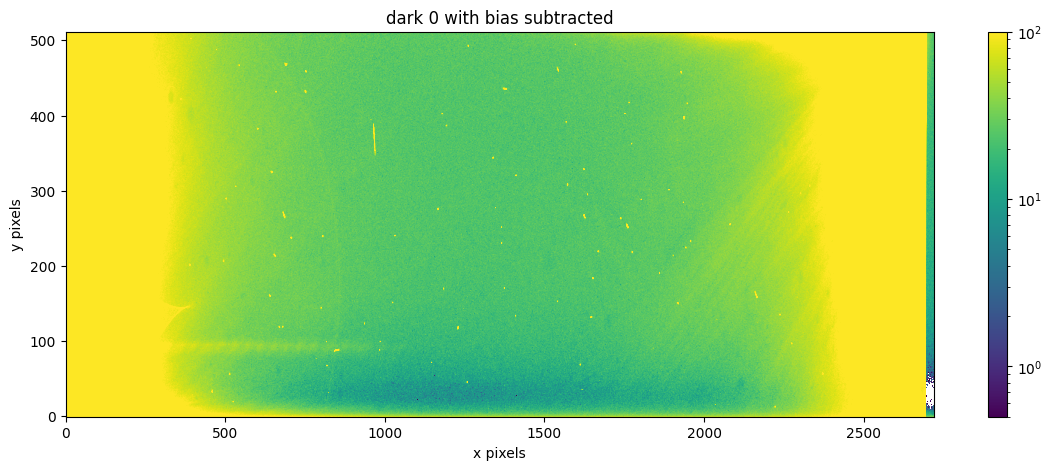

In [157]:
plot_fits(
    dark_data[2], vmin=None, vmax=100, title='dark 0 with bias subtracted', norm='log'
          )

In [147]:
a = 3
b = 3
# a = a - b
a -= b
print(a)

0
